In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import os 

%matplotlib inline

/soft/anaconda/python3/2019.03/CentOS_7/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/soft/anaconda/python3/2019.03/CentOS_7/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
os.getcwd()

'/auto/home/agiamala/rf_mhw'

In [24]:
colnames=['day', 'month','year', 'lon', 'lat', 'mhw_categories', 'Qnet','slp', 'sat', 'wind_speed'] 
allvars = pd.read_csv('all_2lag.csv', names=colnames, header=None)

In [25]:
allvars.head()

,day,month,year,lon,lat,mhw_categories,Qnet,slp,sat,wind_speed
0,31,12,1981,187.5,62.5,0,-59.410534,101250.0,270.380005,3.795424
1,31,12,1981,190.0,62.5,0,-38.894039,101315.0,268.580017,4.496507
2,31,12,1981,192.5,62.5,1,4.918674,101338.0,267.500000,4.744823
3,31,12,1981,195.0,62.5,0,24.337357,101375.0,267.210022,4.819643
4,31,12,1981,197.5,62.5,1,40.749985,101450.0,266.549988,4.297870


In [26]:
allvars.shape

(8451093, 10)

In [27]:
# Labels are the values we want to predict
labels = np.array(allvars['mhw_categories'])

In [28]:
# Remove the labels from the features
# axis 1 refers to the columns
allvars= allvars.drop('mhw_categories', axis = 1)
# Saving feature names for later use
allvars_list = list(allvars.columns)
allvars_list

['day', 'month', 'year', 'lon', 'lat', 'Qnet', 'slp', 'sat', 'wind_speed']

In [29]:
# Convert to numpy array
allvars = np.array(allvars)

In [30]:
# Using Skicit-learn to split data into training and testing sets
# Split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [31]:
# Split the data into training and testing sets
# the random_state parameter is used for initializing the internal random number generator, 
# which will decide the splitting of data into train and test indices.
train_allvars, test_allvars, train_labels, test_labels = train_test_split(allvars, labels, test_size = 0.4, random_state = 42)

In [32]:
print('Training allvars Shape:', train_allvars.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing allvars Shape:', test_allvars.shape)
print('Testing Labels Shape:', test_labels.shape)

Training allvars Shape: (5070655, 9)
Training Labels Shape: (5070655,)
Testing allvars Shape: (3380438, 9)
Testing Labels Shape: (3380438,)


In [13]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with N decision trees
rfc = RandomForestClassifier(n_estimators = 400, min_samples_split=10,min_samples_leaf=1,oob_score=True, random_state = 42)
# Train the model on training data
rfc.fit(train_allvars, train_labels);

In [14]:
print('Score against train set: ', rfc.score(train_allvars, train_labels))
print('OOB Score: ', rfc.oob_score_)
print('Score against test set: ', rfc.score(test_allvars, test_labels))

Score against train set:  0.9645476066064129
OOB Score:  0.9390998309714909
Score against test set:  0.9394787773022928


In [17]:
# Make predictions for the test set
yc_pred_test = rfc.predict(test_allvars)
# Add 1 to be able to do the division for MAPE 
yc_pred_test1=yc_pred_test+1 
test_labels1=test_labels+1

In [18]:
# Calculate the absolute errors
errorsc = abs(yc_pred_test1 - test_labels1)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errorsc), 2))

Mean Absolute Error: 0.08


In [19]:

# Calculate mean absolute percentage error (MAPE)
mapec = 100 * (errorsc / test_labels1)
# Calculate and display accuracy
accuracyc = 100 - np.mean(mapec)
print('Accuracy:', round(accuracyc, 2), '%.')

Accuracy: 96.39 %.


In [20]:
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [21]:
# View confusion matrix for test data and predictions
confusion_matrix(test_labels, yc_pred_test)

array([[3004669,    3973,    6004,     844,      37],
       [ 124803,   36708,    6873,     342,      20],
       [  46352,    3944,   93520,    1628,      12],
       [   3290,     121,    4906,   36772,     109],
       [    324,      14,      81,     867,    3494]])

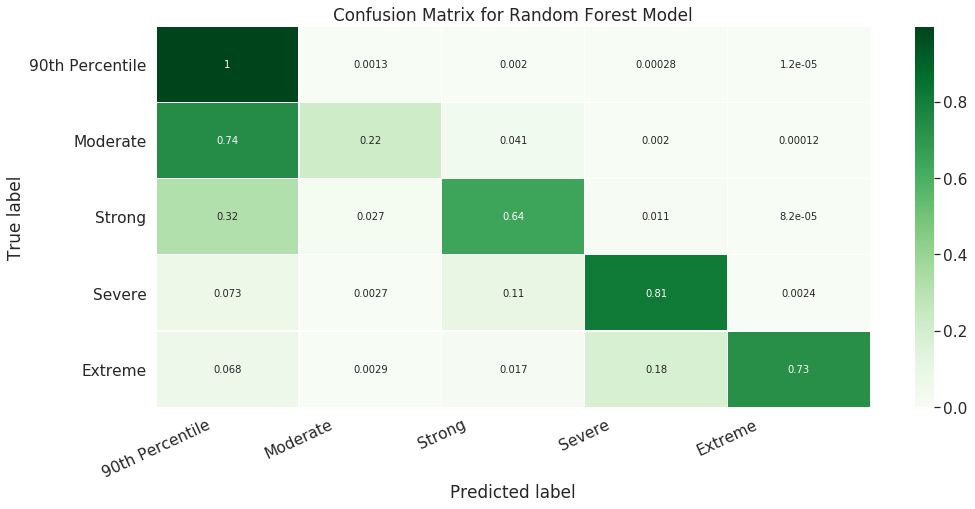

In [22]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(test_labels, yc_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['90th Percentile','Moderate', 'Strong', 'Severe', 
               'Extreme']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [23]:
print(classification_report(test_labels, yc_pred_test))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97   3015527
           1       0.82      0.22      0.34    168746
           2       0.84      0.64      0.73    145456
           3       0.91      0.81      0.86     45198
           4       0.95      0.73      0.83      4780

   micro avg       0.94      0.94      0.94   3379707
   macro avg       0.89      0.68      0.75   3379707
weighted avg       0.93      0.94      0.93   3379707

